In [1]:
import os
import copy

import numpy as np

from nems import Model, visualization

In [2]:
# load data (download if necessary)
signals_dir = "/auto/data/nems_db/recordings"
basename = 'TAR010c-18-2.npz'
datafile = os.path.join(signals_dir, basename)

if not os.path.exists(datafile):
    print(f"Need to download demo data file {datafile}")
    import requests
    prefix = 'https://s3-us-west-2.amazonaws.com/nemspublic/sample_data/'
    uri = prefix + basename
    r = requests.get(uri, stream=True)
    with open(datafile, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    
d = np.load(datafile)

cellid = 'TAR010c-18-2'
fs = 100
X_est=d['X_est']
Y_est=d['Y_est']
X_val=d['X_val']
Y_val=d['Y_val']

In [3]:
# normalize stimulus peak to 1
X_norm = X_est.max()
X_est /= X_norm
X_val /= X_norm

In [4]:
modelspec = 'wc.18x1-fir.15x1-relu.1.o.s'
modelspec = 'wc.18x2-fir.15x2-dexp.1'
model0 = Model.from_keywords(modelspec)
model0.sample_from_priors();

## Scipy backend fit

In [5]:
model_sci = copy.deepcopy(model0)

print('Backend: scipy, Fitting without NL ...')
model_sci.layers[-1].skip_nonlinearity()
fitter_options={'cost_function': 'nmse', 'options': {'ftol': 1e-5, 'maxiter': 100}}
model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options=fitter_options)

print('Backend: scipy, Now fitting with NL ...')
model_sci.layers[-1].unskip_nonlinearity()
fitter_options['options']['ftol'] = 1e-6

model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options=fitter_options)

Backend: scipy, Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00297111...
        Iteration 5, error is: 0.98405254...
        Iteration 10, error is: 0.94478754...
        Iteration 15, error is: 0.91869088...
        Iteration 20, error is: 0.91195483...
        Iteration 25, error is: 0.90757063...
        Iteration 30, error is: 0.90633807...
        Iteration 35, error is: 0.90599271...
        Iteration 40, error is: 0.90567305...
        Iteration 45, error is: 0.90547887...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Backend: scipy, Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 0.89734182...
        Iteration 5, error is: 0.88564702...
        Iteration 10, error is: 0.88180929...
        Iteration 15, error is: 0.87707011...
        Iteration 20, error is: 0.87582863...
        Iteration 25, error is: 0.87517524...
        Iteration 30, error is: 0.87448648...
        Iteration 35, error is: 0.87398

prediction correlation: 0.606


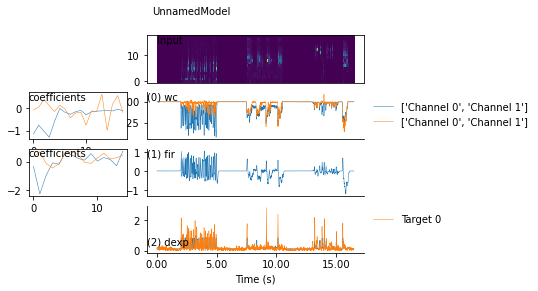

In [6]:
prediction = model_sci.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_sci, X_val, target=Y_val, sampling_rate=fs);

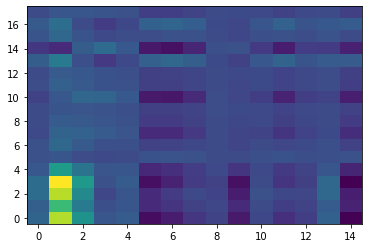

In [7]:
visualization.model.simple_strf(model_sci);

## TF backend fit

In [13]:
model_tf = copy.deepcopy(model0)

fitter_options = {'cost_function': 'loss_se', 'early_stopping_delay': 100, 'early_stopping_patience': 150,
                  'early_stopping_tolerance': 5e-4, 'validation_split': 0.0, 
                  'learning_rate': 5e-3, 'epochs': 2000}

print('Backend: tf, Fitting without NL ...')
model_tf.layers[-1].skip_nonlinearity()
model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

print('Backend: tf, Now fitting with NL ...')
model_tf.layers[-1].unskip_nonlinearity()
fitter_options['learning_rate'] = 1e-4
fitter_options['early_stopping_tolerance'] = 1e-5

model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

Backend: tf, Fitting without NL ...
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 2)          36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         30        
 F)                                                              
                                                                 
 dexp (StaticNonlinearityTF)  (None, 49500, 1)         4         
                                                                 
Total params: 70
Trainable params: 67
Non-trainable params: 3
_________________________________________________________________
None
Epoch 1/2000
1/1 [==============================] - 0s 224ms/step

1/1 [==============================] - 0s 7ms/step - loss: 0.6386
Epoch 182/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6385
Epoch 183/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6383
Epoch 184/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6382
Epoch 185/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6381
Epoch 186/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6380
Epoch 187/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6379
Epoch 188/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6378
Epoch 189/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6377
Epoch 190/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6376
Epoch 191/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6375
Epoch 192/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6374
Epoch 193/2000
1/1 [======================

1/1 [==============================] - 0s 7ms/step - loss: 0.6306
Epoch 384/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6305
Epoch 385/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6305
Epoch 386/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6305
Epoch 387/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6305
Epoch 388/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6305
Epoch 389/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6305
Epoch 390/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6305
Epoch 391/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6304
Epoch 392/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6304
Epoch 393/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6304
Epoch 394/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6304
Epoch 395/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.6289
Epoch 586/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 587/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 588/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 589/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 590/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 591/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 592/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 593/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 594/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 595/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.6289
Epoch 596/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6289
Epoch 597/2000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.7423
Epoch 44/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7417
Epoch 45/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7411
Epoch 46/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7405
Epoch 47/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.7399
Epoch 48/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.7393
Epoch 49/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7387
Epoch 50/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7381
Epoch 51/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7375
Epoch 52/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7369
Epoch 53/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7363
Epoch 54/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7357
Epoch 55/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.6931
Epoch 146/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6928
Epoch 147/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6924
Epoch 148/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6920
Epoch 149/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6917
Epoch 150/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6913
Epoch 151/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6910
Epoch 152/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6906
Epoch 153/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6903
Epoch 154/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6899
Epoch 155/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896
Epoch 156/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6892
Epoch 157/2000
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 0.6487
Epoch 347/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6486
Epoch 348/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6485
Epoch 349/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6483
Epoch 350/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6482
Epoch 351/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6481
Epoch 352/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6480
Epoch 353/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6479
Epoch 354/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6478
Epoch 355/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6477
Epoch 356/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6475
Epoch 357/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6474
Epoch 358/2000
1/1 [============

1/1 [==============================] - 0s 9ms/step - loss: 0.6337
Epoch 548/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6337
Epoch 549/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6336
Epoch 550/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6336
Epoch 551/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6335
Epoch 552/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6335
Epoch 553/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6334
Epoch 554/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6334
Epoch 555/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6333
Epoch 556/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6333
Epoch 557/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6333
Epoch 558/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6332
Epoch 559/2000
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 0.6297
Epoch 649/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6297
Epoch 650/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6296
Epoch 651/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6296
Epoch 652/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6296
Epoch 653/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6295
Epoch 654/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6295
Epoch 655/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6295
Epoch 656/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6294
Epoch 657/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6294
Epoch 658/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6294
Epoch 659/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6293
Epoch 660/2000
1/1 [===========

1/1 [==============================] - 0s 9ms/step - loss: 0.6243
Epoch 849/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6243
Epoch 850/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6243
Epoch 851/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6242
Epoch 852/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6242
Epoch 853/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6242
Epoch 854/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6242
Epoch 855/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6242
Epoch 856/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6241
Epoch 857/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6241
Epoch 858/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6241
Epoch 859/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6241
Epoch 860/2000
1/1 [======================

1/1 [==============================] - 0s 13ms/step - loss: 0.6224
Epoch 950/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.6224
Epoch 951/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.6224
Epoch 952/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.6224
Epoch 953/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.6223
Epoch 954/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.6223
Epoch 955/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.6223
Epoch 956/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.6223
Epoch 957/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.6223
Epoch 958/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.6223
Epoch 959/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6222
Epoch 960/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6222
Epoch 961/2000
1/1 [===================

1/1 [==============================] - 0s 10ms/step - loss: 0.6209
Epoch 1050/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6209
Epoch 1051/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6209
Epoch 1052/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6209
Epoch 1053/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6209
Epoch 1054/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6209
Epoch 1055/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6209
Epoch 1056/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6209
Epoch 1057/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6208
Epoch 1058/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6208
Epoch 1059/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6208
Epoch 1060/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6208
Epoch 1061/2000
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: 0.6198
Epoch 1150/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6198
Epoch 1151/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6198
Epoch 1152/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6198
Epoch 1153/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6198
Epoch 1154/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6198
Epoch 1155/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6198
Epoch 1156/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6197
Epoch 1157/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6197
Epoch 1158/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6197
Epoch 1159/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6197
Epoch 1160/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6197
Epoch 1161/2000
1/1 [===========

1/1 [==============================] - 0s 9ms/step - loss: 0.6183
Epoch 1348/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6183
Epoch 1349/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6183
Epoch 1350/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6183
Epoch 1351/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6183
Epoch 1352/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6183
Epoch 1353/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6183
Epoch 1354/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6183
Epoch 1355/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6182
Epoch 1356/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6182
Epoch 1357/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6182
Epoch 1358/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6182
Epoch 1359/2000
1/1 [===========

1/1 [==============================] - 0s 7ms/step - loss: 0.6178
Epoch 1448/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6178
Epoch 1449/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6178
Epoch 1450/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6178
Epoch 1451/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6178
Epoch 1452/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.6177
Epoch 1453/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6177
Epoch 1454/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6177
Epoch 1455/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6177
Epoch 1456/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6177
Epoch 1457/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6177
Epoch 1458/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6177
Epoch 1459/2000
1/1 [=======

1/1 [==============================] - 0s 6ms/step - loss: 0.6174
Epoch 1548/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6173
Epoch 1549/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6173
Epoch 1550/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.6173
Epoch 1551/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6173
Epoch 1552/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6173
Epoch 1553/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6173
Epoch 1554/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6173
Epoch 1555/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6173
Epoch 1556/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6173
Epoch 1557/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6173
Epoch 1558/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6173
Epoch 1559/2000
1/1 [===========

1/1 [==============================] - 0s 6ms/step - loss: 0.6170
Epoch 1648/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6170
Epoch 1649/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6170
Epoch 1650/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6170
Epoch 1651/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6170
Epoch 1652/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6170
Epoch 1653/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6170
Epoch 1654/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6170
Epoch 1655/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6170
Epoch 1656/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6170
Epoch 1657/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6170
Epoch 1658/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6170
Epoch 1659/2000
1/1 [===========

1/1 [==============================] - 0s 7ms/step - loss: 0.6167
Epoch 1748/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6167
Epoch 1749/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6167
Epoch 1750/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.6167
Epoch 1751/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6167
Epoch 1752/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6167
Epoch 1753/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6167
Epoch 1754/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6167
Epoch 1755/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6167
Epoch 1756/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6167
Epoch 1757/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6167
Epoch 1758/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6167
Epoch 1759/2000
1/1 [=========

Epoch 1847/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6165
Epoch 1848/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6165
Epoch 1849/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6165
Epoch 1850/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6165
Epoch 1851/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6165
Epoch 1852/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6164
Epoch 1853/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6164
Epoch 1854/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6164
Epoch 1855/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6164
Epoch 1856/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6164
Epoch 1857/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6164
Epoch 1858/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6164
Epoch 1859/2000

prediction correlation: 0.551


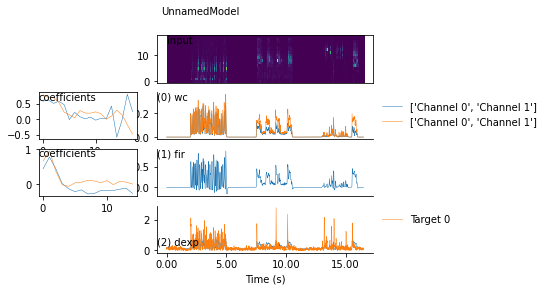

In [11]:
prediction = model_tf.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_tf, X_val, target=Y_val, sampling_rate=fs);

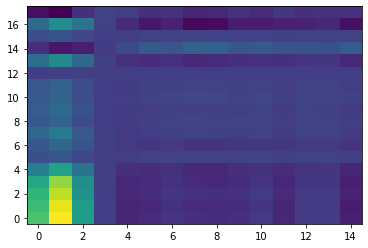

In [12]:
visualization.model.simple_strf(model_tf);